## 3. Signal processing / System identification

#### Signal processing (Consider two analyses in different frequency bands)
- ~~Filter and Decimation (IIR Filter)~~ (sample has been sampled already in the desired frequency band to keep uq less complex)
    - $M = $ ~~Number of IIR filter coefficients ("order")~~
    - $f_c =$ ~~Filter 3 dB cutoff frequency~~
    - $d = $ ~~Decimation rate (every d-th sample)~~
- $\hat{\Phi}(\omega)$ Spectral estimator (Welch, Blackman-Tukey)
    - Time / Lag Window (If PSDs are involved)  <br>**TODO: Which window types to include (rectangular, hanning, hamming, etc.)?**
    - $ 2 (n_\mathrm{lags} - 1) = n_\mathrm{lines}$ Number of time lags ↔ number of frequency lines ($\tau_\mathrm{max} = n_\mathrm{lags} \Delta t$ Correlation length ↔ Frequency Resolution $\Delta f = \frac{f_s}{n_\mathrm{lines}}$)
- use non-reference based OMA ($n_\mathrm{ref}$ Number and $\operatorname{loc}_\mathrm{ref}$ location of reference channels) 

#### Systemidentification
- $n_\mathrm{ord}^\mathrm{max} = $ max model order
- Identification Algorithm (SSI-cov, SSI-data, pLSCF) -> Three case studies, pLSCF might need some work in terms of verification, efficiency, etc.

#### Outputs
- PSD Energy
- **TODO: Cross-validated reconstruction error of the identified system**
    - reconstruction: Correlation function (CF) synthetization is available
    - cross-validation: use different samples for identification and comparison (repeat multiple times)
        - it might not be covered by theory to use portions of the CF in the lag-domain for identification, i.e. all specified lags are needed for idnetification
        - treat different blocks as samples and use k-fold cross validation
        - parameters $n_{blocks}$ and $k$

In [94]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext snakeviz
# dont forget to forward ports: ssh -L 8080:127.0.0.1:8080 sima9999@makalu47.rz.tu-ilmenau.de

import sys
import os
sys.path.append("/home/sima9999/code/")
sys.path.append("/home/sima9999/git/pyOMA/")
from pathlib import Path


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from examples.UQ_OMA import vars_definition, pair_modes

import ray

from uncertainty.polymorphic_uncertainty import PolyUQ
from uncertainty.data_manager import DataManager

from model.acquisition import Acquire, sensor_position

import pyOMA

from pyOMA.core.PreProcessingTools import PreProcessSignals, GeometryProcessor, SignalPlot
from pyOMA.core.SSICovRef import BRSSICovRef, plot_corr_synth

import logging


%aimport -sys -logging -matplotlib -matplotlib.pyplot -numpy -pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


## Parameters

In [2]:
result_dir = Path('/usr/scratch4/sima9999/work/modal_uq/uq_oma_a/')
working_dir = Path('/dev/shm/womo1998/')

### Uncertainty Propagation

In [2]:
vars_ale, vars_epi, arg_vars = vars_definition(stage=3)
dim_ex = 'cartesian'

# %%snakeviz
N_mcs_ale = 1000
N_mcs_epi = 1000
use_dm = True


In [3]:
# poly_uq2 = poly_uq

poly_uq = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
if False:
    
    poly_uq_stage1 = PolyUQ(vars_ale, vars_epi, dim_ex=dim_ex)
    poly_uq_stage1.load_state(os.path.join(result_dir,'polyuq_samp_stage1.npz'), differential='samp')
    poly_uq.sample_qmc(N_mcs_ale, N_mcs_epi, check_sample_sizes=False, seed=poly_uq_stage1.seed)
    display(poly_uq.var_supp)
    
    '''
    Apparently there were some bugs in QMC, that were fixed in 1.11 and changed the way Halton
    Sequences are scrambled. Therefore reproducibility is broken, and existing samples must be
    copied to the new sequences manually
    affects first variable (reverting fixes it):
    https://github.com/scipy/scipy/commit/75371c5cb8a10f4a4172f8670f0ee53546b61796
    affects all further variables:
    https://github.com/scipy/scipy/commit/4c5d0e39a24ed39e0d242194b11671a45c55d067
    
    '''
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        poly_uq.inp_samp_prim[var_name] = poly_uq_stage1.inp_samp_prim[var_name]
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        poly_uq.inp_suppl_ale[var_name] = poly_uq_stage1.inp_suppl_ale[var_name]
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        poly_uq.inp_suppl_epi[var_name] = poly_uq_stage1.inp_suppl_epi[var_name]
    poly_uq.save_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    # check, that samples are indeed the same
    for var_name in list(poly_uq_stage1.inp_samp_prim.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_samp_prim[var_name][:], poly_uq.inp_samp_prim[var_name][:])
        plt.title(var_name)
    for var_name in list(poly_uq_stage1.inp_suppl_ale.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_suppl_ale[var_name], poly_uq.inp_suppl_ale[var_name])
        plt.title(var_name)
    for var_name in list(poly_uq_stage1.inp_suppl_epi.columns):
        plt.figure()
        plt.scatter(poly_uq_stage1.inp_suppl_epi[var_name], poly_uq.inp_suppl_epi[var_name])
        plt.title(var_name)
    
else:
    poly_uq.load_state(os.path.join(result_dir,'polyuq_samp.npz'), differential='samp')
    

if False:
    import seaborn as sns
    sns.pairplot(poly_uq.inp_samp_prim, kind='hist')
    plt.gcf().set_size_inches((18,18))

if False:
    dm_grid, dm_ale, dm_epi = poly_uq.to_data_manager('dm_oma_a', result_dir=result_dir / 'samples')
else:
    dm_grid = None


INFO:uncertainty.polymorphic_uncertainty:Loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/polyuq_samp.npz


In [6]:
dm_grid = None
if dm_grid is None:
    dm_grid = DataManager.from_existing('dm_oma_a.nc',
                                        result_dir = result_dir / 'samples', 
                                        working_dir = '/dev/shm/womo1998/')

todo = False    


while todo:    
    todo = dm_grid.evaluate_samples(stage3mapping, arg_vars, 
                         ret_names={'bits_effective':(), 'snr_db_est':(), 
                                    'snr_db':()}, default_len={'node':203, 'dir':2}, 
                         use_lock=False, dry_run=False, re_eval_sample=False, distributed=True,
                         chunks_submit=10000, chunks_save=500, scramble_evaluation=False,
                                   remote_kwargs={'num_cpus':1, 'memory':4300 * 1024 * 1024})


In [ ]:
ray.shutdown()

### Signal Processing


In [3]:
jid = '0e8132ee_0e9f1c84'
seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')

if not isinstance(result_dir, Path):
    result_dir = Path(result_dir)

if not isinstance(working_dir, Path):
    working_dir = Path(working_dir)

    
# Set up directories
if '_' in jid:
    id_ale, id_epi = jid.split('_')
    this_result_dir = result_dir / 'samples' / id_ale
    this_result_dir = this_result_dir / id_epi
    
    seed = int.from_bytes(bytes(jid, 'utf-8'), 'big')
    
acqui_c = Acquire.load(this_result_dir / 'measurement.npz', differential='sampled')


INFO:model.acquisition:Now loading previous results from  /usr/scratch4/sima9999/work/modal_uq/uq_oma_a/samples/0e8132ee/0e9f1c84/measurement.npz


In [4]:
pd_kwargs = acqui_c.to_prep_data()
ref_channels=np.where(acqui_c.channel_defs[:,0]==201)[0]
prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs, ref_channels=ref_channels)

INFO:model.acquisition:Using a sampled signal


#### decimation

- prior to decimation, the signal has been 
  - largely oversampled [35,70] Hz, (with the intent to reduce sampling noise)
  - mdoerately oversampled [10, 35] Hz, (to account for incomplete knowledge of actual natural frequncies)
  - sampled at the final bandwidth [4, 10] Hz (naive approach)
- the analyst might want to downsample to the desired bandwidth, 
- the analyst has some knowledge from the provided numerical study (with uncertainties) 
  - that the highest natural frequency to identify will be at around 4 Hz (up to fifth-oder modes), 
  - but might also decide modes only up to the third order might be of interest (2 Hz)
- the analyst might be more or less knowledgeable and
  - run the analysis, using the signal as-is (naive approach)
  - downsample moderately (nyquist at twice the highest natural frequency of interest) (conservative approach)
  - downsample agressively (nyquist just above the highest natural frequency of interest) (high-risk approach)
- cutoff frequency / decimation factor must be translated into a meaningful parameter for uq
- final sampling frequency depends on the smaller value of this and the present nyquist rate
- these dependent parameters cannot be used directly for uq
- possible solutions: 
  - define approaches to OMA as parameter sets and do uq over these discrete sets (no optimization possible)
  - actually sampling and downsampling belong together, the choice is to either:
    - oversample and use-as-is out of missing experience (inexperienced)
    - oversample first and then downsample (conservative)
    - sample at the final bandwidth from the beginning (naive)
- **decision**
  - **do'nt do any further decimation here**  

In [75]:
prep_signals = pyOMA.core.PreProcessingTools.PreProcessSignals(**pd_kwargs)
print(prep_signals.sampling_rate)
M = 4
fc = 5
d = 2
prep_signals.decimate_signals(d, nyq_rat = prep_signals.sampling_rate / fc, order=M)


70.0
INFO:pyOMA.core.PreProcessingTools:Decimating signals by factor 2 to a sampling rate of 35.0 Hz
INFO:pyOMA.core.PreProcessingTools:Filtering signals in the band: None .. 2.5 with a 4 order cheby1 filter.


In [76]:

n_lags = 200
n_blocks = 30
prep_signals.corr_matrix_bt = None
prep_signals.corr_blackman_tukey(n_lags, num_blocks=n_blocks, refs_only=True)
prep_signals.corr_matrices_bt.shape

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=200 and num_blocks=30...
....................................................................................................


(30, 10, 10, 200)

#### Display Signals

INFO:pyOMA.core.PreProcessingTools:Estimating Correlation Functions (BT) with n_lags=200 and num_blocks=1...
....................................................................................................


(array([<AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>,
        <AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>],
       dtype=object),
 array([<AxesSubplot: xlabel='$f$ [Hz]', ylabel='Singular Value Magnitude [dB]'>,
        <AxesSubplot: xlabel='$f$ [Hz]', ylab

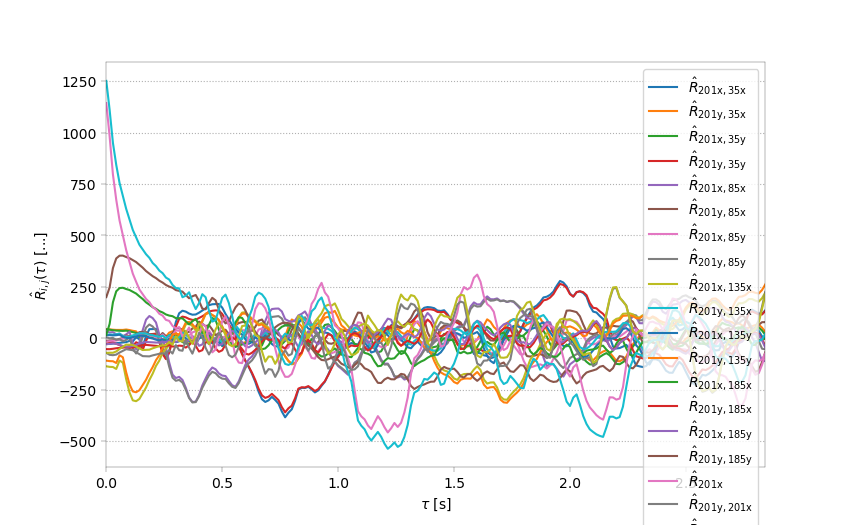

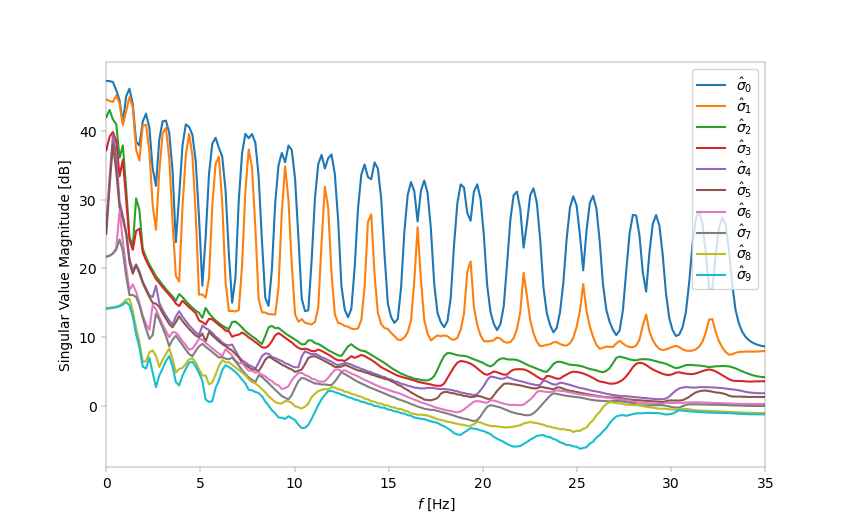

In [60]:
pyOMA.core.PreProcessingTools.SignalPlot(prep_signals).plot_signals(timescale='lags', psd_scale='svd')

### System Identification

In [77]:
modal_data = BRSSICovRef(prep_signals)

### Reconstruction Error method

The reconstruction error of any system identification method is estimated by a $k$-fold cross validation method \cite{arlot...}. A part of the signal is used for system identification, and the system output is validated against the remaining part. System input and output must not necessarily be timestep signals, but can also be correlation functions, spectral densities, or other derived quantities depending on the employed identification method. In the following the method is given for the covariance-driven Stochastic Subspace Identification method.

The measured signal is divided into $n_{blocks}$ blocks for all channels. The correlation function of the signal from two channels $f$ and $g$ is then computed for each of these blocks using the Blackman-Tukey operator $$\hat{R}_{fg}[m] = \frac{1}{N_{block} - m}\sum_{n=0}^{N_{block} - m - 1} f[n] g[n + m] \; \text{,}$$ where $N_{block}$ is the blocklength in timesteps, and $m$ is the lag step of the correlation function. To avoid large confidence intervals of the correlation function for short blocklengths $N_{block}$ and high lags $m$, the second input signal $g[n+m]$ is allowed to overlap into the consecutive block by $m$ timesteps. The average $\hat{R}_{fg}[m]$ over $(k - 1) \lfloor \frac{n_{blocks}}{k}\rfloor $ randomly selected   blocks is used as input for system identification [^1]. The remainig $\lfloor \frac{n_{blocks}}{k}\rfloor $  are used for system validation. 

Given an identified stochstic state-space model in modally decoupled form $$\mathbf{x}_{j}[k+1] = \mathbf{\Lambda}_d \mathbf{x}_{j}[k] + \mathbf{w}_{j}[k]$$ $$ \mathbf{y}[k] = \mathbf{\Phi}x_{j}[k] + \mathbf{v}_{j}[k] \, \text{,}$$ where $j$ is the mode number,  \cite{reynders2012...} have demonstrated the synthetizaton of correlation functions.
$$ \mathbf{\tilde{R}}^\mathfrak{m}_{fg}[m] = \sum_{j=1}^{n_\mathfrak{m}} \lambda_{j}^{m-1}\mathbf{\phi}_{j}\mathbf{g}_{j}^T$$ and the modal participation vector $\mathbf{g}^\mathfrak{m}_{j}$ is the $j^\mathrm{th}$ column of the modally decomposed next-state output covariance matrix $\mathbf{G}^\mathrm{ref} = \mathbf{\Psi} \mathbf{G}^\mathfrak{m}$.

- Here/Mapping: rebuild corr_matrix_bt from indices
- BRSSICovRef: implement custom corr_matrix_data in single_order_modal (l 326) 
- BRSSICovRef: implement non-modally-decomposed synthetization and single reconstruction error
- Here/Mapping: Average reconstruction error
- test procedures
    
[^1]$\frac{1}{n_{blocks}} \sum_{i=1}^{n_{blocks}} \hat{R}_{fg,i}[m] = \hat{R}_{fg,i}[m]$

In [78]:
rng = np.random.default_rng(seed)
k = 4
block_length = n_blocks // k
block_indices = np.arange(block_length*k)
rng.shuffle(block_indices)
block_indices

array([25, 24, 27, 10, 14,  4, 26,  9, 15,  8, 23,  6, 17,  2, 11, 18,  7,
       19,  3, 20, 13,  1, 16,  0, 21, 22,  5, 12])

In [79]:
pyOMA.core.PreProcessingTools.SignalPlot(prep_signals).plot_correlation(channels=[0], refs=[8,9])

<AxesSubplot: xlabel='$\\tau$ [s]', ylabel='$\\hat{R}_{i,j}(\\tau)$ [...]'>

Assembling toeplitz matrix using pre-computed correlation functions 100 block-columns and 101 block rows
Computing state matrices with pinv-based method, with maximum model order 30...
Assembling toeplitz matrix using pre-computed correlation functions 100 block-columns and 101 block rows
Computing state matrices with pinv-based method, with maximum model order 30...
Assembling toeplitz matrix using pre-computed correlation functions 100 block-columns and 101 block rows
Computing state matrices with pinv-based method, with maximum model order 30...
Assembling toeplitz matrix using pre-computed correlation functions 100 block-columns and 101 block rows
Computing state matrices with pinv-based method, with maximum model order 30...


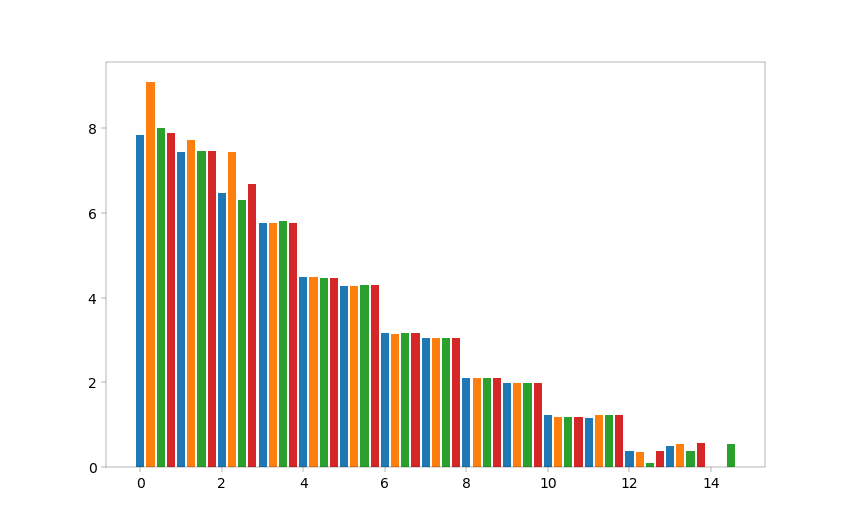

In [16]:
order = 30
plt.figure()

for i in range(k):
    test_set = block_indices[i * block_length:(i + 1) * block_length]
    training_set = np.take(block_indices, np.arange((i + 1) * block_length, (i + k) * block_length), mode='wrap')
    prep_signals.corr_matrix_bt = np.mean(prep_signals.corr_matrices_bt[training_set,...], axis=0)
    modal_data.build_toeplitz_cov(prep_signals.n_lags // 2)
    modal_data.compute_state_matrices(order)
    this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, this_modal_contributions = \
                    modal_data.single_order_modal(order, plot_=False, corr_synth=True)
    nonzero = this_modal_frequencies != 0
    plt.bar(np.arange(np.sum(nonzero))+i/k, this_modal_frequencies[nonzero], width=0.8/k)


Assembling toeplitz matrix using pre-computed correlation functions 100 block-columns and 101 block rows
Computing state matrices with pinv-based method, with maximum model order 14...


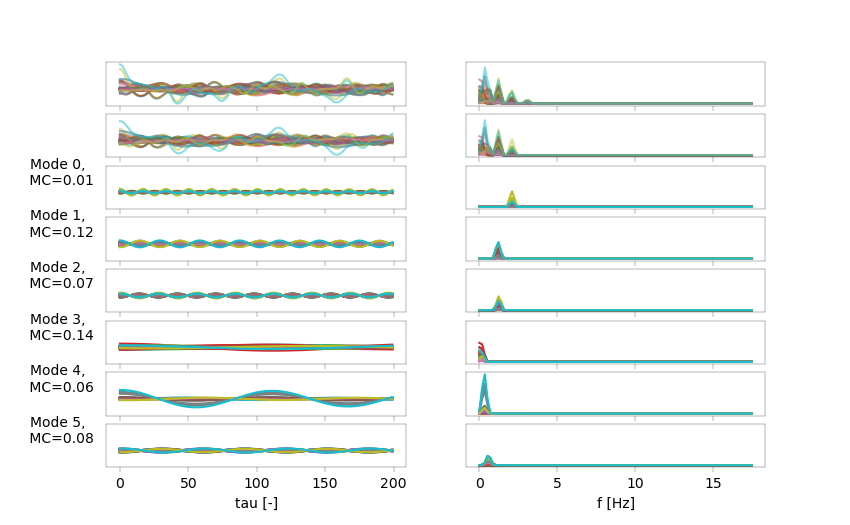

In [86]:
logger= logging.getLogger('pyOMA.core.SSICovRef')
logger.setLevel(level=logging.INFO)
order = 14
modal_data.build_toeplitz_cov(prep_signals.n_lags // 2)
modal_data.compute_state_matrices(order)
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, this_modal_contributions = \
                modal_data.single_order_modal(order, plot_modes=True, synth_corr=True)
nonzero = this_modal_frequencies != 0
this_modal_frequencies = this_modal_frequencies[nonzero]
this_modal_damping = this_modal_damping[nonzero]
this_eigenvalues = this_eigenvalues[nonzero]
this_modal_contributions = this_modal_contributions[nonzero]
this_mode_shapes = this_mode_shapes[:,nonzero]

In [106]:
order = 30
modal_data.build_toeplitz_cov(prep_signals.n_lags // 2)
modal_data.compute_state_matrices(order)
this_modal_frequencies, this_modal_damping, this_mode_shapes, this_eigenvalues, this_modal_contributions = \
                modal_data.single_order_modal(order,  synth_corr=True)
nonzero = this_modal_frequencies != 0
this_modal_frequencies = this_modal_frequencies[nonzero]
this_modal_damping = this_modal_damping[nonzero]
this_eigenvalues = this_eigenvalues[nonzero]
this_modal_contributions = this_modal_contributions[nonzero]
this_mode_shapes = this_mode_shapes[:,nonzero]

Assembling toeplitz matrix using pre-computed correlation functions 100 block-columns and 101 block rows
Computing state matrices with pinv-based method, with maximum model order 30...


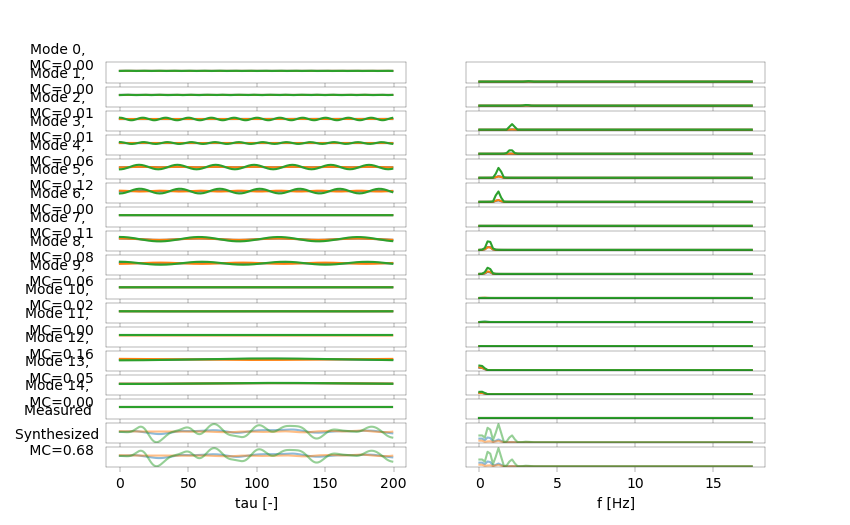

In [111]:
plot_corr_synth(modal_data, 
                # modelist=[0,1], 
                channel_list=[6,7,8], 
                ref_channel_list=[0]
               )

# continue
# check why MC is less than 1, when it actually looks like perfect reconstrucion

In [98]:
np.sum(this_modal_contributions)

0.4726546638162868

#### Modal analysis (manual)

In [263]:
modal_data.compute_modal_params()

Computing modal parameters...
....................................................................................................


In [264]:
from pyOMA.core.StabilDiagram import StabilCalc, StabilPlot
from pyOMA.core.PlotMSH import ModeShapePlot

from pyOMA.GUI.JupyterGUI import PlotMSHWeb, StabilGUIWeb, SnappingCursor, OutputWidgetHandler, ConfigGUIWeb

In [265]:
stabil_calc = StabilCalc(modal_data, prep_signals)
stabil_plot = StabilPlot(stabil_calc)

display(StabilGUIWeb(stabil_plot))

Checking stabilisation criteria...
....................................................................................................


#### Mode shape visualization (numerical, identified, manually identified)

In [359]:
from pyOMA.core.PostProcessingTools import MergePoSER

channel_defs = acqui_c.channel_defs, 
channel_headers = pd_kwargs['channel_headers']
coordinates = np.copy(channel_defs[0])
coordinates[:,1:3] = 0
coordinates = np.roll(coordinates, -1, axis=1)
nodes = {str(coordinates[i*2,2]):list(coordinates[i*2,:]) for i in range(len(channel_headers)//2)}
lines = [([coordinates[i*2,2], coordinates[i*2+2, 2]]) for i in range(len(channel_headers)//2 - 1)]
chan_dofs = []
for i in range(len(channel_defs[0])):
    channel_name = channel_headers[i]
    node = str(coordinates[i,2])
    az, elev = [(0, 0), (270, 0), (90, 0)][channel_defs[0][i,1]]
    chan_dofs.append([i, node, az, elev, channel_name])
geometry = GeometryProcessor(nodes, lines)
prep_signals.chan_dofs = []
prep_signals.add_chan_dofs(chan_dofs)

In [506]:
inds_num, inds_ident, unp_num, unp_ident = pair_modes(
    acqui_c.modal_frequencies_samp, this_modal_frequencies, 
    acqui_c.mode_shapes_samp, this_mode_shapes, 
    freq_thresh=0.2, mac_thresh=0.6)

all_inds_ident = np.concatenate((inds_ident, unp_ident))
corr_inds_num = np.ma.concatenate((inds_num, np.ma.array(np.zeros_like(unp_ident), mask=np.ones_like(unp_ident, dtype=bool))))

# indices of numerical modes in the order of identified modes (for each id mode the index of num mode of nan)
corr_inds_num_sort = corr_inds_num[np.argsort(all_inds_ident)] 

'''
assume numerical frequencies to be sorted ascendingly

indices should be usable to:
    - reduce both sets of modal parameters to their matching sets (inds_num, inds_ident)
    - leading set are the identified modal parameters, they are stored in the database unordered, none should be discarded
    - assign identified modal parameters to numerical ones (corr_inds_num_sort
        - for each identified modal parameter
        - set the index of the corresponding numerical modal parameter
        - if there is no corresponding, mask the value
'''
corr_inds_num_sort

masked_array(data=[--, --, 9, 8, 7, 6, 4, --],
             mask=[ True,  True, False, False, False, False, False,  True],
       fill_value=999999)

In [507]:
num_freqs_corr = np.ma.array(acqui_c.modal_frequencies_samp[corr_inds_num_sort], 
                             mask=corr_inds_num_sort.mask, 
                             fill_value=np.nan
                            ).filled()
num_damps_corr = np.ma.array(acqui_c.modal_damping_samp[corr_inds_num_sort] * 100, 
                             mask=corr_inds_num_sort.mask, 
                             fill_value=np.nan
                            ).filled()
num_msh_corr = np.ma.array(acqui_c.mode_shapes_samp[:,corr_inds_num_sort], 
                           mask=np.repeat(corr_inds_num_sort.mask[np.newaxis, :], acqui_c.mode_shapes_samp.shape[0], axis=0), 
                           fill_value=np.nan
                          ).filled()


freq_diffs = num_freqs_corr - this_modal_frequencies
damp_diffs = num_damps_corr - this_modal_damping
mac_matrix = StabilCalc.calculateMAC(num_msh_corr, this_mode_shapes)


macs = np.diag(mac_matrix)
display(f'Statistics on identification: Δf = {np.nanmean(freq_diffs):1.3f}± {np.nanstd(freq_diffs):1.3f}, Δd = {np.nanmean(damp_diffs):1.3f}± {np.nanstd(damp_diffs):1.3f}, MAC: mean = {np.nanmean(macs):1.3f}, min= {np.nanmin(macs):1.3f}, Number of unmatched identified modes {len(unp_ident)}')


'Statistics on identification: Δf = 0.003± 0.002, Δd = -0.837± 1.005, MAC: mean = 0.929, min= 0.753, Number of unmatched identified modes 3'

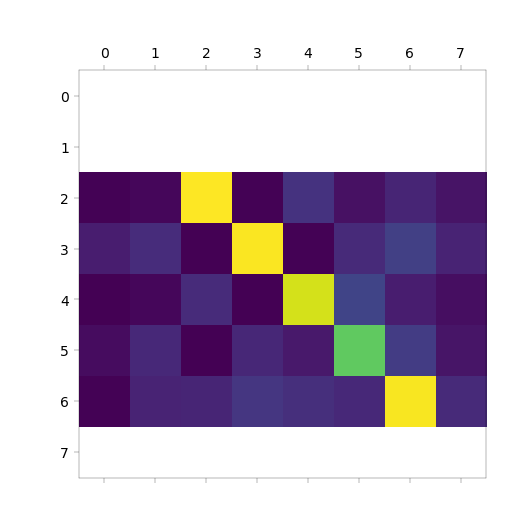

In [508]:
plt.matshow(mac_matrix)

##### Manual

In [267]:
mode_shape_plot = ModeShapePlot(amplitude=10,
                                prep_data=prep_signals,
                                stabil_calc=stabil_calc,
                                geometry_data=geometry,
                                modal_data=modal_data)

##### Numerical

In [509]:
merged_data = MergePoSER()

merged_data.mean_damping = acqui_c.modal_damping_samp[inds_num,np.newaxis]
merged_data.mean_frequencies = acqui_c.modal_frequencies_samp[inds_num,np.newaxis]
merged_data.std_frequencies = np.zeros_like(merged_data.mean_damping)
merged_data.std_damping = np.zeros_like(merged_data.mean_damping)
merged_data.merged_mode_shapes = acqui_c.mode_shapes_samp[:,np.newaxis,inds_num]# (total_dofs, 1, common_modes)
merged_data.merged_num_channels = merged_data.merged_mode_shapes.shape[0]
merged_data.merged_chan_dofs = chan_dofs

In [510]:
mode_shape_plot_num = ModeShapePlot(amplitude=10,
                               merged_data=merged_data, 
                                geometry_data=geometry,
                               )
mode_shape_plot = mode_shape_plot_num

##### Identified

In [511]:
merged_data = MergePoSER()

merged_data.mean_damping = this_modal_damping[inds_ident,np.newaxis]
merged_data.mean_frequencies = this_modal_frequencies[inds_ident,np.newaxis]
merged_data.std_frequencies = np.zeros_like(merged_data.mean_damping)
merged_data.std_damping = np.zeros_like(merged_data.mean_damping)
merged_data.merged_mode_shapes = this_mode_shapes[:,np.newaxis,inds_ident]# (total_dofs, 1, common_modes)
merged_data.merged_num_channels = merged_data.merged_mode_shapes.shape[0]
merged_data.merged_chan_dofs = chan_dofs

In [512]:
mode_shape_plot_id = ModeShapePlot(amplitude=10,
                               merged_data=merged_data, 
                                geometry_data=geometry,
                               )
mode_shape_plot = mode_shape_plot_id

### Display

In [399]:
display(PlotMSHWeb(mode_shape_plot))

In [521]:
mode_shape_plot_num.reset_view()
mode_shape_plot_id.reset_view()

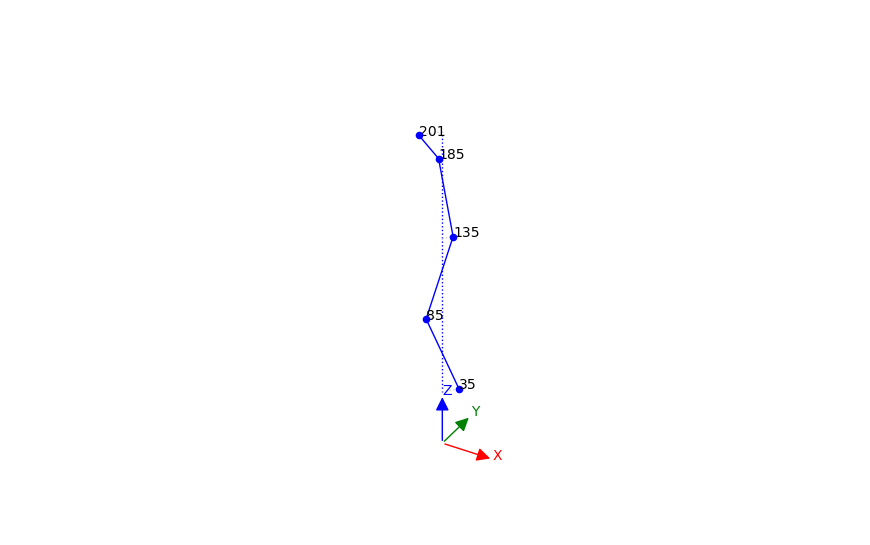

1.1995156332018202

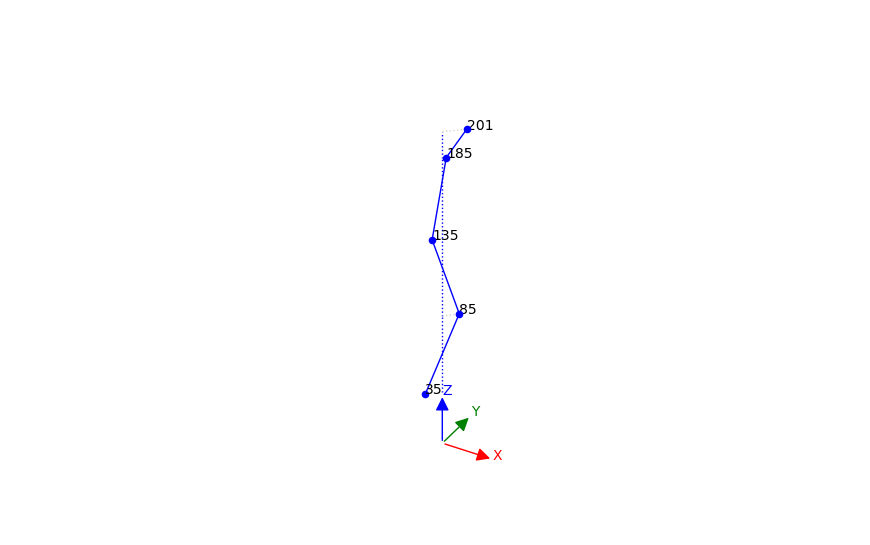

1.1980469802369533

In [534]:
ind=3
_,_,frequency_num,_,_,_,_ = mode_shape_plot_num.change_mode(index=ind)
_,_,frequency_id,_,_,_,_ = mode_shape_plot_id.change_mode(index=ind)
display(mode_shape_plot_num.fig, frequency_num, mode_shape_plot_id.fig,frequency_id)

## Continue

Further test mapping parameters noise etc for any unwanted/unrealistic effects on the identification
 - verification manually or automatic
   - automatic (see UQ_Acqui.ipynb): 
     - proper modepairing with numerical where excess-modes may be present in both numerical and identified
     - statistics on MAC, frequency deviations, damping deviations, number of unmatched identified modes
     - MAC might have a problem with rotated modeshapes
     - available for inclusion in mapping and final verification
     - also modeshape order and major/minor direction can be marked for each identified mode to validate any output-only method for mode clustering


    
check modeshape rotation with a different example (where alpha is odd)     
then just choose a different example and see, if everything works as expected

- get bounds of every parameter
- run full factorial over bounds
- 


